# PROACT Dataset

In [7]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from utility.survival import make_time_bins
from SurvivalEVAL.Evaluations.util import KaplanMeier

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

from utility.plot import load_tf_color
TFColor = load_tf_color()

df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed.csv'), index_col=0)
event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']
for event_name in event_names:
    df = df.loc[(df[f'Event_{event_name}'] == 0) | (df[f'Event_{event_name}'] == 1)] # drop left-censored
    df = df.loc[(df[f'TTE_{event_name}'] > 0) & (df[f'TTE_{event_name}'] <= 500)] # 1 - 365
df = df.drop(df.filter(like='_Strength').columns, axis=1) # Drop strength tests
df = df.drop('Race_Caucasian', axis=1) # Drop race information
df = df.drop('El_escorial', axis=1) # Drop el_escorial
df = df.drop(['Height', 'Weight', 'BMI'], axis=1) # Drop height/weight/bmi

In [8]:
event_times = df[["TTE_Speech", "TTE_Swallowing", "TTE_Handwriting", "TTE_Walking"]].to_numpy()
event_indicators = df[["Event_Speech", "Event_Swallowing", "Event_Handwriting", "Event_Walking"]].to_numpy()
masked_event_times = np.where(event_indicators == 1, event_times, np.nan)
min_time = np.nanmin(masked_event_times)
max_time = np.nanmax(masked_event_times)
mean_time = np.nanmean(masked_event_times)
print(min_time)
print(max_time)
print(mean_time)

1.0
365.0
149.3733583489681


In [9]:
event_times.shape

(2969, 4)

In [10]:
df

,Diagnosis_Delta,TTE_Speech,Event_Speech,TTE_Swallowing,Event_Swallowing,TTE_Handwriting,Event_Handwriting,TTE_Walking,Event_Walking,ALSFRS_R_Total,Age,Sex,Site_of_Onset,Onset_Delta,DiseaseProgressionRate,Subject_used_Riluzole,Event_Death,TTE_Death,FVC_Mean
0,24.0,311.0,0.0,311.0,0.0,64.0,1.0,311.0,0.0,35.0,29.0,Male,Limb,-597.0,0.653266,No,False,311.0,3.980000
4,156.0,333.0,0.0,333.0,0.0,290.0,1.0,96.0,1.0,41.0,67.0,Female,Limb,-481.0,0.436590,Yes,False,333.0,2.120000
5,298.0,171.0,0.0,171.0,0.0,171.0,1.0,171.0,0.0,34.0,74.0,Male,Limb,-1060.0,0.396226,Yes,False,171.0,NaN
6,21.0,182.0,0.0,182.0,0.0,182.0,0.0,182.0,0.0,41.0,74.0,Male,NaN,-439.0,0.478360,Yes,False,182.0,2.846667
10,396.0,93.0,0.0,93.0,0.0,93.0,0.0,93.0,0.0,43.0,73.0,Female,NaN,-549.0,0.273224,Yes,False,93.0,1.873333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,215.0,96.0,1.0,264.0,0.0,264.0,0.0,236.0,1.0,NaN,61.0,Female,NaN,-310.0,NaN,NaN,True,344.0,3.550000
5897,427.0,340.0,0.0,340.0,0.0,340.0,0.0,340.0,0.0,46.0,69.0,Male,NaN,-1169.0,0.051326,NaN,False,340.0,NaN
5899,976.0,275.0,0.0,275.0,0.0,275.0,0.0,275.0,0.0,NaN,53.0,Male,NaN,-1525.0,NaN,NaN,False,275.0,3.963333
5903,470.0,340.0,0.0,340.0,0.0,340.0,0.0,84.0,1.0,32.0,52.0,Female,NaN,-855.0,0.561404,NaN,False,340.0,NaN


In [11]:
# Print event distribution
for event_col in event_names:
    obs_arr = np.array(df[f"Event_{event_col}"])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round((obs_arr.shape[0]-n_censored) / obs_arr.shape[0] * 100, 2)}% of records are uncensored\n")

Number of samples: 2969
Number of censored/uncensored: 2371.0/598.0
20.14% of records are uncensored

Number of samples: 2969
Number of censored/uncensored: 2559.0/410.0
13.81% of records are uncensored

Number of samples: 2969
Number of censored/uncensored: 2097.0/872.0
29.37% of records are uncensored

Number of samples: 2969
Number of censored/uncensored: 2184.0/785.0
26.44% of records are uncensored



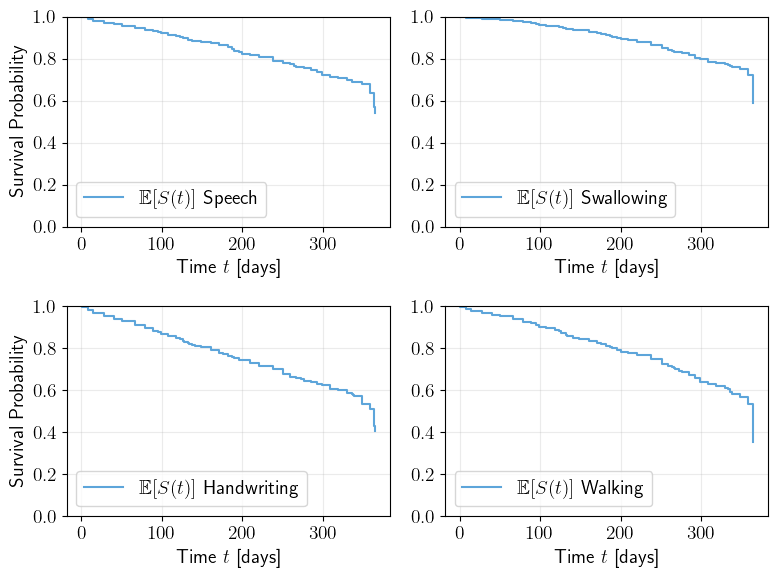

In [12]:
# Plot KM curves ["Communication", "Movement", "Swallowing", "Breathing"]
event_times = df[['TTE_Speech', 'TTE_Swallowing', 'TTE_Handwriting', 'TTE_Walking']].to_numpy()
event_indicators = df[['Event_Speech', 'Event_Swallowing', 'Event_Handwriting', 'Event_Walking']].to_numpy()

time_bins = make_time_bins(event_times, event=None)
time_bins = torch.cat((torch.tensor([0]), time_bins))

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for event_id in range(4): # 4 events
    times = event_times[:, event_id]
    indicators = event_indicators[:, event_id]
    
    km_model = KaplanMeier(times, indicators)
    km_surv_prob = torch.from_numpy(km_model.predict(time_bins)).numpy()
    
    # Plotting the survival curve
    axes[event_id].step(time_bins.numpy(), km_surv_prob, where='post',
                        label=r"$\mathbb{E}[S(t)]$" + f" {event_names[event_id]}", color=TFColor[3])
    axes[event_id].set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        axes[event_id].set_ylabel("Survival Probability")
    axes[event_id].set_ylim(0, 1)
    axes[event_id].legend(loc='lower left') 
    axes[event_id].grid(True, alpha=0.25)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/proact_km_curves.pdf", format='pdf', bbox_inches='tight')
plt.show()